In [1]:
import numpy as np
import pandas as pd
import cv2
import mahotas
import os
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import io
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from pathlib import Path

In [2]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = 1000
    # display.precision = 2  # set as needed

set_pandas_display_options()

Number of images:  422
C:\Users\Shadow\Documents\Projets\MastereIA\DataChallenge\histopathological\exploration\..\data\input\Train\SOB_B_A-14-22549AB-100-001.png


<function skimage.io._io.show()>

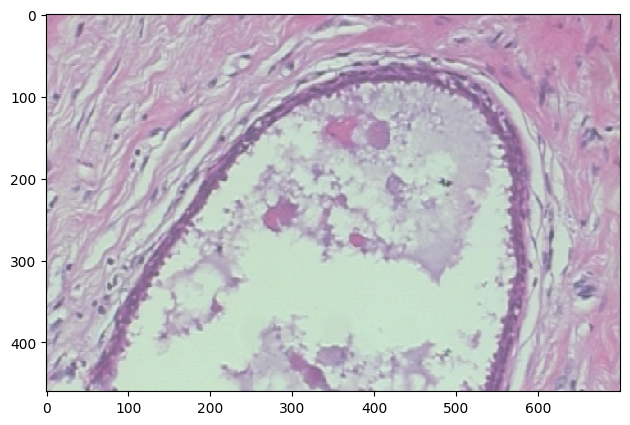

In [10]:
from skimage import io
import os

wd = os.path.join(os.getcwd(), '..')
data = os.path.join(wd, 'data', 'input')
image_train_path = os.path.join(data, 'Train')

# get images list from folder using os.listdir
images = os.listdir(path=image_train_path)
images = [image for image in images if Path(image).suffix == '.png']

# Number of images
print("Number of images: ", len(images))

# Image visualisation
print(os.path.join(image_train_path,images[0]))
io.imshow(os.path.join(image_train_path,images[0]))
io.show

## Dataset building
* Now we can build a pandas DataFrame to store the information about the images. All the informations are contained in the filename of each image.

* For example, SOB_B_TA-14-4659-40-001.png is the image 1, at magnification factor 40X, of a benign tumor of type tubular adenoma, original from the slide 14-4659, which was collected by procedure SOB.

* Using the function str.split we can create new columns in the dataframe corresponding to the class, subclass and slide from each image.

In [4]:
def parse_fn(filename):
    # <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>-<YEAR>-<SLIDE_ID>-<MAG>-<SEQ>
    parsed = filename[:-4].replace('-', '_').split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'class', 'type', 'magnification', 'slide', 'mag', 'seq', 'filename']

df = pd.DataFrame(list(map(parse_fn, images)), columns=columns)
label_types = df['type'].unique()
print(label_types)
print(df.head())

['A' 'F' 'PT' 'TA' 'DC' 'LC' 'MC' 'PC']
  procedure class type magnification    slide  mag  seq                        filename
0       SOB     B    A            14  22549AB  100  001  SOB_B_A-14-22549AB-100-001.png
1       SOB     B    A            14  22549AB  100  002  SOB_B_A-14-22549AB-100-002.png
2       SOB     B    A            14  22549AB  100  003  SOB_B_A-14-22549AB-100-003.png
3       SOB     B    A            14  22549AB  100  005  SOB_B_A-14-22549AB-100-005.png
4       SOB     B    A            14  22549AB  100  006  SOB_B_A-14-22549AB-100-006.png


Encoding MUST be done with the following correspondance

F->1 DC->2 PC->3 PT->4 MC->5 LC->6 A->7 TA->8

In [5]:
label_maps = {'F':'1', 'DC':'2', 'PC':'3', 'PT':'4', 'MC':'5', 'LC':'6', 'A':'7', 'TA':'8'}
df['type_id'] = df['type'].apply(lambda x: label_maps[x])

print(df.head(10))

  procedure class type magnification    slide  mag  seq                        filename type_id
0       SOB     B    A            14  22549AB  100  001  SOB_B_A-14-22549AB-100-001.png       7
1       SOB     B    A            14  22549AB  100  002  SOB_B_A-14-22549AB-100-002.png       7
2       SOB     B    A            14  22549AB  100  003  SOB_B_A-14-22549AB-100-003.png       7
3       SOB     B    A            14  22549AB  100  005  SOB_B_A-14-22549AB-100-005.png       7
4       SOB     B    A            14  22549AB  100  006  SOB_B_A-14-22549AB-100-006.png       7
5       SOB     B    A            14  22549AB  100  013  SOB_B_A-14-22549AB-100-013.png       7
6       SOB     B    A            14  22549AB  100  014  SOB_B_A-14-22549AB-100-014.png       7
7       SOB     B    A            14  22549AB  100  015  SOB_B_A-14-22549AB-100-015.png       7
8       SOB     B    A            14  22549AB  100  018  SOB_B_A-14-22549AB-100-018.png       7
9       SOB     B    A            14  22

<AxesSubplot: xlabel='type', ylabel='Count'>

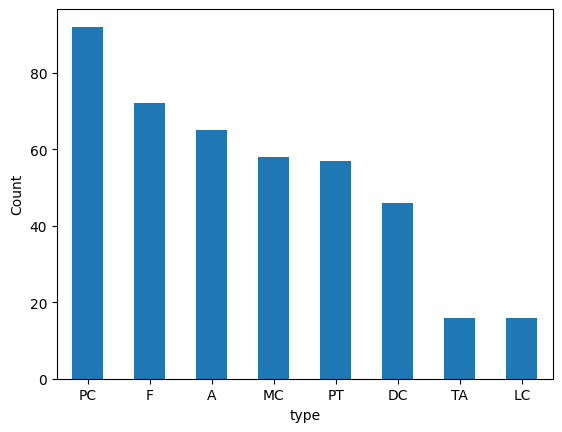

In [6]:
df_B_type = df[df['class'] == 'B']
df_B_type['type'].value_counts().plot(kind='bar', xlabel='type', ylabel='Count', rot=0)

df_M_type = df[df['class']== 'M']
df_M_type['type'].value_counts().plot(kind='bar', xlabel = 'type', ylabel='Count', rot=0)

df['type'].value_counts().plot(kind='bar', xlabel = 'type', ylabel='Count', rot=0)

* Now you can create a more advanced visualisation of the images like shown below by using ImageGrid object from the matplotlib library (https://matplotlib.org/3.1.3/gallery/axes_grid1/simple_axesgrid.html). Here we visualise the 4 first images of each class.

C:\Users\Shadow\AppData\Local\Temp\ipykernel_6216\3894601579.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


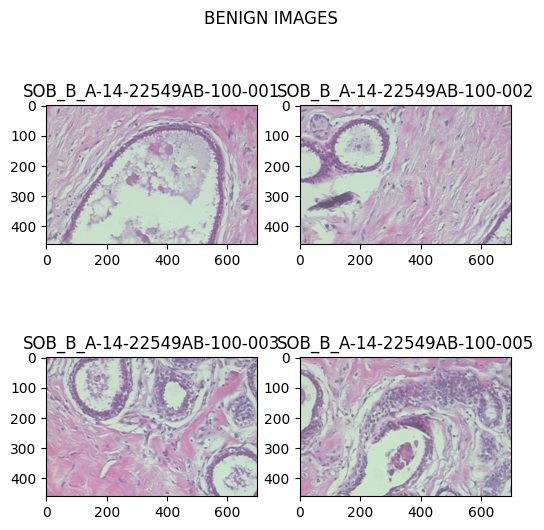

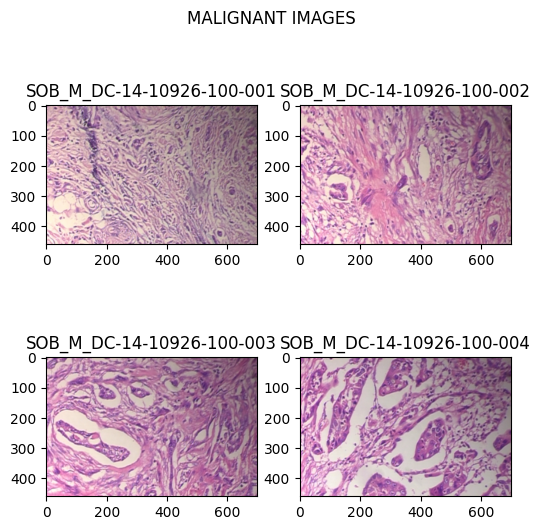

In [11]:
# plot 4 images for each class
b_img = df[df['class'] == 'B'].head(4)
m_img = df[df['class'] == 'M'].head(4)

for class_name, class_images in [['BENIGN', b_img], ['MALIGNANT', m_img]]:
    fig, axs = plt.subplots(2,2,figsize=(6, 6))
    fig.suptitle('{0} IMAGES'.format(class_name), fontsize=12)
    i = 0
    j = 0
    for idx, img in class_images.iterrows():
        ax = axs[i, j]
        ax.set_title(img['filename'][:-4])
        ax.imshow(io.imread(os.path.join(image_train_path, img['filename'])))
        j = j + 1 if j < 1 else 0
        i = i + 1 if j == 0 else i
    fig.show()

## Examples of features extraction (from image processing)
* To perform machine learning, you need to map each image to a vector or representation.

* Feature extraction is necessary to extract information from the raw data, in order to enrich their description. Selecting the most meaningful features is a crucial step in the process of classification problems.

* The selected set of features should be a small set whose values efficiently discriminate among patterns of the different classes, but are similar for patterns within the same class.

* Here we will calculate 3 global features on each image. To do so, we can use functions from OpenCV and mahotas libraries:
    * Hu moments: https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html
    * Haralick: https://mahotas.readthedocs.io/en/latest/features.html
    * Color histogram in HSV: https://docs.opencv.org/master/dd/d0d/tutorial_py_2d_histogram.html

In [8]:
# parameters for the features extraction
bins = 8

# functions to extract features from the images
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

*Concatenation of the features for each image in the list to extend the DataFrame defined earlier. Note that there are 7 values for the Hu moments, 13 for the Haralick features and 512 for the histogram. At the end, the DataFrame contains 532 values between 0 and 1 for the global features calculated.

In [12]:
# Compute the features
feat_haralick = []
feat_histogram = []
feat_hu = []

for i in images:
    img = cv2.imread(os.path.join(image_train_path, i))  # Load image
    feat_hu.append(fd_hu_moments(img))  # Append Hu values
    feat_haralick.append(fd_haralick(img))  # Append Haralick values
    feat_histogram.append(fd_histogram(img))  # Append Histogram values

In [4]:
# Concatenate with the original data frame 
df_features = np.hstack([feat_haralick, feat_hu, feat_histogram])
df_features = pd.DataFrame(df_features)
df_features.shape

NameError: name 'np' is not defined